# SK하이닉스 기계학습 프로그램
## Regularization Techniques for Training Neural Networks

실습 일시: 2019년 7월 25일 (목)

담당 조교: 이한국 (hankook.lee@kaist.ac.kr)

# Part 0. Introduction

<img src="overfitting.png" width="100%"/>

본 실습에서는, 강의 내용을 바탕으로, 주어진 다층신경망의 학습할 때 생기는 과적합(overfitting) 문제를 해결하기 위한 방법인 정규화(regularization) 방법 중 몇 가지를 배우는 것을 목표로 합니다.
이를 위해, 본 실습은 총 3 파트로 구성이 됩니다.

* **Part 1. Keras를 이용한 인공신경망 모델 학습**
  * Tensorflow(https://www.tensorflow.org/api_docs/python/tf)와 Keras(https://keras.io/) API를 활용한 모델 학습 구현
  * 간단한 data augmentation을 적용하여 overfitting 문제 해결 및 성능 개선
* **Part 2. Advanced data agumentation techiqnues**
  * Cutout (https://arxiv.org/pdf/1708.04552.pdf)
  * Mixup (https://arxiv.org/abs/1710.09412)
  * CutMix (https://arxiv.org/abs/1905.04899)
* **Part 3. Other techniques (Optional)**
  * Dropout (http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
  * Weight Regularization

**Part 1**에서는, Tensorflow의 high-level API인 Keras를 활용하여 모델을 학습하는 방법을 배웁니다. 그리고, 간단한 data augmentation을 적용해보고, over-fitting이 어떻게 해결되는지 확인해볼 예정입니다.
**Part 2**에서는, 최근 data augmentation 기법들을 직접 구현해보고, 이를 통해 성능이 얼마나 개선되는지를 확인해볼 것입니다.
**Part 3**에서는, data augmentation 외에 다른 몇가지 방법에 대해 다룰 예정입니다. **Part 3**은 평가 요소에 포함되지 않으니, 보고서 작성까지 끝나신 분들은 이 부분에 대해서도 추가적으로 학습해보시길 권해드립니다.

각 파트에는, 여러분들이 직접 해결해야 할 연습문제가 포함되어 있습니다: **Task** 와 같은 형태로 표시되어 있습니다. 실습을 진행하면서, 해당 문제를 해결하고 이에 대한 보고서를 간략히 작성해주셔야 합니다. 작성된 보고서는 조교 메일을 통해 제출해 주시길 바랍니다.

In [1]:
# 실습에서 사용할 모듈을 import 합니다.

# IPYthon 상에서 matplotlib 라이브러리가 
# 별도의 창 없이 즉시 plot을 출력할 수 있도록 설정을 변경합니다.
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.grid'] = False

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

# "즉시 실행" (eager execution) 기능을 활성화합니다.
# 즉시 실행 활성화로 TensorFlow를 대화형 프론트엔드(frontend)에 가깝게 만들어 줍니다.
# 해당 기능은 TensorFlow 2.0 부터는 기본적으로 활성화됩니다. 
# tf.enable_eager_execution()
# print("Eager execution: {}".format(tf.executing_eagerly()))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [2]:
# 본 실습에서 사용할 데이터셋인 cifar10과, data augmentation을 위한 api인 ImageDataGenerator를 import해줍니다.
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Part 1. Keras를 이용한 인공신경망 모델 학습
Keras는 Tensorflow의 high-level API 중 하나입니다. Keras를 이용하면 Neural Network를 쉽게 정의하고, 학습할 수 있습니다. 여러가지 사전 정의된 레이어와 데이터가 많기 때문에, 기계학습을 처음 배우시거나, 혹은 간단한 실험을 돌리기에 매우 적합합니다. **Part 1**에서는 TensorFlow와 Keras를 이용하여 작은 neural network를 정의하고, 이를 cifar10 데이터셋에서 학습해볼 예정입니다.

In [3]:
# 실습 과정에서 도움이 되는 함수들을 정의합니다.

def plot_images(images_or_generator, rows=4, cols=8):
    """matplotlib package를 이용하여 이미지를 그려주는 함수입니다."""
    
    import types
    if isinstance(images_or_generator, types.GeneratorType):
        images = []
        n = 0
        for x, y in images_or_generator:
            images.append(x)
            n += x.shape[0]
            if n >= rows*cols:
                break
        images = np.concatenate(images, axis=0)
    else:
        images = images_or_generator
        
    n = 0
    plt.figure(figsize=(16, 8))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        
def sample_dataset(x, y, samples_per_class=100):
    """dataset의 일부분만 추출해내는 함수입니다. 본 실습에서는 많은 양의 데이터를 사용할 수 없기 때문에, 데이터의 일부만 사용합니다."""
    
    from collections import defaultdict
    count = defaultdict(int)
    indices = []
    for i in range(x.shape[0]):
        if count[y[i, 0]] < samples_per_class:
            count[y[i, 0]] += 1
            indices.append(i)
    return x[indices], y[indices]

def plot_history(history):
    """학습 과정에서의 loss/accuracy의 변화를 그래프로 그려줍니다. 또, 가장 높게 도달했던 accuracy를 출력해줍니다."""
    
    epochs = len(history.history['loss'])
    val_steps = len(history.history['loss']) // len(history.history['val_loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(range(epochs), history.history['loss'], 'r')
    plt.plot(range(0, epochs, val_steps), history.history['val_loss'], 'b')
    plt.legend(['train', 'test'])

    plt.subplot(1, 2, 2)
    plt.title('accuracy')
    plt.plot(range(epochs), history.history['acc'], 'r--')
    plt.plot(range(0, epochs, val_steps), history.history['val_acc'], 'b--')
    plt.legend(['train', 'test'])

    print('최대 도달 성능: %.2f' % (max(history.history['val_acc'])*100,))

먼저, cifar10 데이터를 로드하고, 그 데이터에 어떤 사진들이 들어있는지 확인해봅니다.

In [4]:
# Keras의 모듈을 이용하여 cifar10 데이터를 로드합니다. 3분 이내의 시간이면 데이터를 다운로드할 수 있습니다.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 59s 0us/step


In [5]:
# 사전정의된 함수 sample_dataset을 이용하여 데이터셋의 일부만 사용합니다. 각 class마다 총 100장의 이미지만 사용합니다.
x_train, y_train = sample_dataset(x_train, y_train, samples_per_class=100)

In [6]:
# training/test 셋에 얼마나 많은 수의 데이터가 들어가있는지 확인합니다.
print('이미지 크기: %d x %d x %d' % (x_train.shape[1], x_train.shape[2], x_train.shape[3]))
print('')
print('트레이닝 샘플 수: %d' % x_train.shape[0])
print('트레이닝 데이터 크기: %d x %d x %d x %d' % (*x_train.shape, ))
print('')
print('테스트 샘플 수: %d' % x_test.shape[0])
print('테스트 데이터 크기: %d x %d x %d x %d' % (*x_test.shape, ))

이미지 크기: 32 x 32 x 3

트레이닝 샘플 수: 1000
트레이닝 데이터 크기: 1000 x 32 x 32 x 3

테스트 샘플 수: 10000
테스트 데이터 크기: 10000 x 32 x 32 x 3


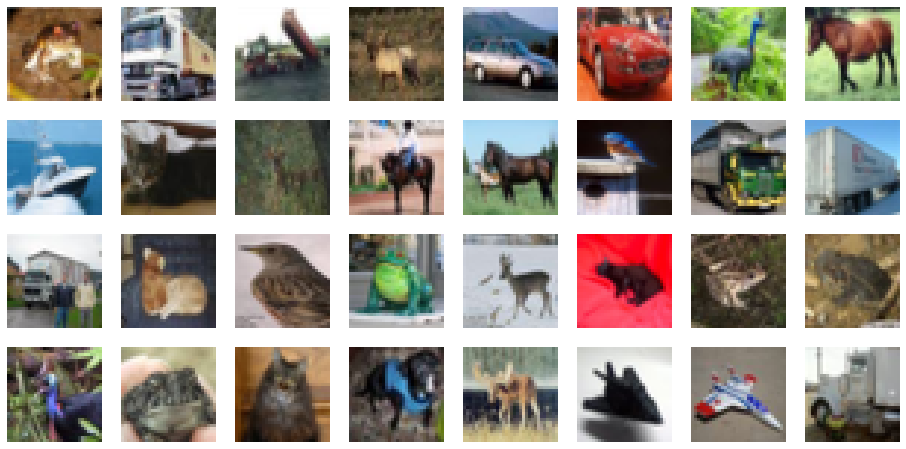

In [7]:
# 사전정의된 함수 plot_images를 이용하여 dataset을 확인해볼 수 있습니다.
plot_images(x_train)

### 데이터 전처리 과정
이미지의 pixel 의 값은 (R, G, B) 형태로 표현되고, 각 channel (R/G/B) 마다 0부터 255 중 하나의 정수 값을 가집니다. 인공신경망은 일반적으로 실수형 데이터를 처리하기에 적합합니다. 또라서, 다음과 같이 0부터 1 사이의 실수값으로 변경해줍니다.

In [8]:
# 이미지 값을 0부터 1 사이의 값으로 변경합니다.
x_train = x_train / 255.0
x_test = x_test / 255.0

label의 값은 0부터 9까지의 정수로 표현됩니다. classification 문제를 풀 때는 일반적으로 one-hot encoding을 하여 확률값처럼 고려할 수 있도록 합니다. 아래의 keras API를 이용해 one-hot encoding으로 바꾸어줍니다.

In [9]:
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
# one-hot encoding 예시
print(y_train[:5])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 모델 정의 및 파라미터 저장
Keras에는 모델을 쉽게 정의할 수 있는 API가 포함되어있습니다. 아래 목록은 실습에서 사용할 Keras 레이어입니다. 자세한 정보는 Keras 공식 사이트(https://keras.io/)에서 확인하실 수 있습니다.
- `tf.keras.layers.Conv2D`: image와 같이 W x H x C 형태로 되어있는 입력을 다룰 수 있는 convoluiontal layer를 의미합니다.
- `tf.keras.layers.MaxPooling2D`: image와 같은 입력을 max pooling하는 layer입니다.
- `tf.keras.layers.GlobalAveragePooling2D`: 모든 spatial dimension에 대해 average pooling해주는 layer로, 입력이 W x H x C 형태라면 출력은 1 x 1 x C 가 됩니다.
- `tf.keras.layers.Flatten`: multi-dimensional input을 vector로 치환해주는 layer입니다. 예를 들어, 3-dimension input (W x H x C 형태)를 1-dimension output (WHC 형태)로 치환해줍니다.
- `tf.keras.layers.Dense`: Fully-connected layer를 의미합니다.

Keras에서는 여러가지 layer를 연속적으로 연결해주는 `tf.keras.models.Sequential` 클래스도 제공을 합니다. 이를 이용하여, 아래와 같이 4-layer CNN을 쉽게 정의할 수 있습니다. 또, `summary()` 함수를 이용하면, 함수가 어떻게 정의되었는지 확인할 수 있습니다.

In [452]:
# Keras API를 이용하여 모델을 정의합니다.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [453]:
# 정의된 모델은 summary 함수를 통해 다시 확인할 수 있습니다.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

In [454]:
# 모델의 initial parameter를 저장해줍니다.
model.save_weights('init_weights.h5')

### Hyperparameters
이번 학습에서 사용할 hyperparameter입니다.

In [14]:
batch_size = 32
steps_per_epoch = (x_train.shape[0]+batch_size-1) // batch_size * 10
num_epochs = 30

## Task 1: Mini-batch

첫 번째 task에서는 Keras에서 Data Generator가 하는 역할을 배웁니다. 아래의 빈칸 코드를 채워서 임의의 순서로 mini-batch를 만들도록 해보세요.

- `_data_generation` 함수의 `batch_ids`에는 어떤 sample을 포함해야하는지. sample의 번호로 적혀있습니다. 예를 들어, `batch_ids=[0,4,5]`이면, mini-batch에는 dataset의 1,5,6번째 데이터를 포함해야합니다.
- 데이터 정보는 `self.x_data`, 클래스 정보는 `self.y_data`에 담겨있습니다.
- 최종 결과값을 `x`와 `y`에 저장한 뒤, return해주도록 구현하시면 됩니다.
- **아래의 세 가지 내용에 대해 보고서에 첨부해주세요.**
  - 빈칸의 코드
  - `plot_images`를 이용한 image 출력 결과
  - `plot_history`를 이용한 최종 학습 결과
  - 최종 학습 결과를 토대로, over-fitting이 발생했는지 확인해봅니다. (training loss는 하락하지만, test loss가 더 이상 하락하지 않으면 over-fitting이 발생했다고 볼 수 있습니다.)

In [16]:
class BatchGenerator():
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(x_data)

    def __call__(self):
        """generator를 return해줍니다."""
        while True:
            indexes = self._get_exploration_order() # mini-batch 구성 순서를 불러옵니다.
            for i in range(0, self.num_samples, self.batch_size):
                batch_ids = indexes[i:i+self.batch_size] # batch_size만큼 batch_ids를 가져옵니다.
                x, y = self._data_generation(batch_ids)
                yield x, y

    def _get_exploration_order(self):
        """이번 epoch에서 mini-batch의 순서를 결정해줍니다."""
        indexes = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indexes)
        return indexes

    def _data_generation(self, batch_ids):
        """"mini-batch를 구성하여 return해줍니다."""
        
        ### FILL YOUR OWN CODE (#1) ###
        # batch_ids를 기반으로, mini-batch를 구성합니다.
        batch_size = len(batch_ids)
        x = self.x_data[batch_ids]
        y = self.y_data[batch_ids]
        ###############################

        return x, y

CIFAR의 training data (`x_train`, `y_train`) 를 이용하여 training generator를 생성합니다.

In [24]:
training_generator = BatchGenerator(x_train, y_train, batch_size=batch_size)

생성된 generator를 이용하여 mini-batch의 sample들을 plotting해보아 mini-batch가 잘 구성되었는지 확인해봅니다. 여러번 실행해보아 random하게 mini-batch가 구성되는지도 확인합니다.

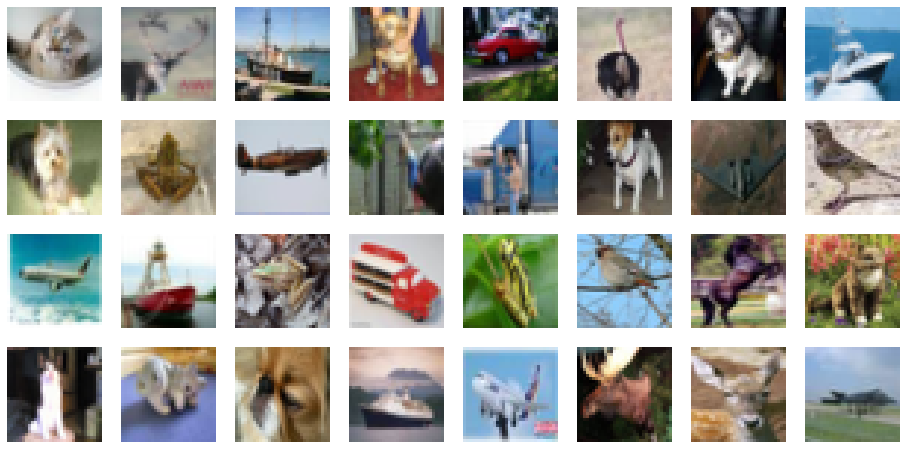

In [29]:
# __call__ 함수를 불러야 generator가 return되기 때문에, 함수처럼 () 를 사용하셔야 합니다.
plot_images(training_generator())

Keras에서는 모델 API 중 하나인 `complie`은 어떤 optimizer(SGD, Adam, RMSProp 등)을 사용할 것인지, 어떤 loss로 optimization할 것인지, 또 evaluation metric은 무엇인지를 손쉽게 정의할 수 있습니다. 저희는 `adam` optimizer를 사용할 예정이고, classification 문제를 위한 loss인 `categorical_crossentropy`를 사용할 것입니다. 그리고 evaluation을 위한 metric은 classification `accuracy`를 사용합니다.

In [19]:
model.load_weights('init_weights.h5') # compile하기 전, 먼저 모델을 초기화해줍니다.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Keras Model API 중 하나인 `fit_generator`를 이용하여 쉽게 모델을 학습해볼 수 있습니다. 이 함수는 학습 과정에서 기록된 여러 수치들을 기록해두고, return값으로 반환합니다. 이 기록(`history`)을 이용하여 학습의 결과를 확인해볼 수 있습니다.

In [20]:
history = model.fit_generator(
    generator=training_generator(),
    steps_per_epoch=steps_per_epoch, # 각 epoch마다 모델을 update하는 횟수입니다.
    epochs=num_epochs, # 학습에 사용할 총 epoch 수입니다.
    validation_data=(x_test, y_test), # evaluation에 사용할 데이터입니다.
    verbose=2)

Epoch 1/30
 - 5s - loss: 1.9805 - acc: 0.2482 - val_loss: 1.8625 - val_acc: 0.3206
Epoch 2/30
 - 2s - loss: 1.6631 - acc: 0.3861 - val_loss: 1.7117 - val_acc: 0.3852
Epoch 3/30
 - 2s - loss: 1.5210 - acc: 0.4438 - val_loss: 1.6352 - val_acc: 0.4033
Epoch 4/30
 - 2s - loss: 1.3809 - acc: 0.4907 - val_loss: 1.5615 - val_acc: 0.4382
Epoch 5/30
 - 2s - loss: 1.2676 - acc: 0.5405 - val_loss: 1.5213 - val_acc: 0.4503
Epoch 6/30
 - 2s - loss: 1.1461 - acc: 0.5807 - val_loss: 1.5499 - val_acc: 0.4530
Epoch 7/30
 - 2s - loss: 1.0253 - acc: 0.6278 - val_loss: 1.5046 - val_acc: 0.4836
Epoch 8/30
 - 2s - loss: 0.9356 - acc: 0.6579 - val_loss: 1.5232 - val_acc: 0.4773
Epoch 9/30
 - 2s - loss: 0.8227 - acc: 0.7048 - val_loss: 1.6208 - val_acc: 0.4665
Epoch 10/30
 - 2s - loss: 0.7478 - acc: 0.7352 - val_loss: 1.6618 - val_acc: 0.4742
Epoch 11/30
 - 2s - loss: 0.6629 - acc: 0.7711 - val_loss: 1.6843 - val_acc: 0.4756
Epoch 12/30
 - 2s - loss: 0.6102 - acc: 0.7817 - val_loss: 1.7810 - val_acc: 0.4787
E

최대 도달 성능: 49.59


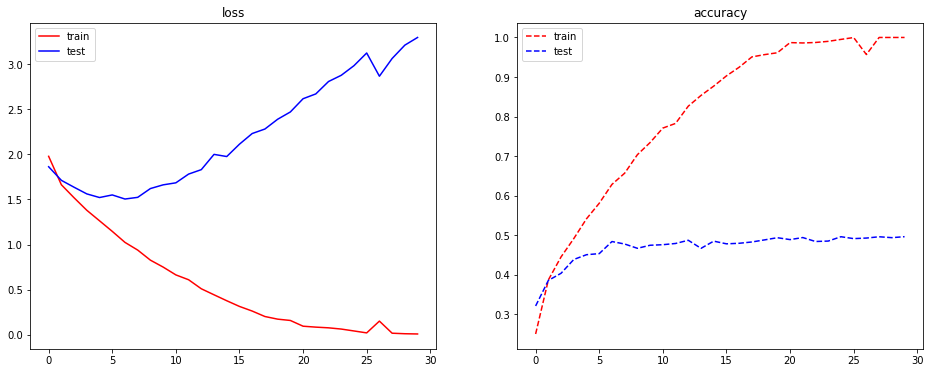

In [21]:
plot_history(history)

## Task 2: Mini-batch with Data Augmentation

두 번째 task에서는 Keras에서 제공되는 DataGenerator API를 이용하여 간단한 data augmentation을 해볼 예정입니다. 아래의 빈칸 코드를 채워서 augmentation이 된 mini-batch를 만들도록 해보세요.

- `datagen.random_transform` 함수를 이용하면 각 image에 대해 data augmentation을 적용할 수 있습니다.
- batch 안의 모든 데이터에 대해 data augmentation을 적용하세요.
- 최종 결과값을 `x`와 `y`에 저장한 뒤, return해주도록 구현하시면 됩니다.
- **아래의 세 가지 내용에 대해 보고서에 첨부해주세요.**
  - 빈칸의 코드
  - `plot_images`를 이용한 image 출력 결과
  - `plot_history`를 이용한 최종 학습 결과
  - 최종 학습 결과를 토대로, over-fitting이 발생했는지 확인해봅니다. 또, 이전의 실험결과과 비교해 어떤 결과가 발생했는지 확인해봅니다.

`tf.keras.preprocessing.image.ImageDataGenerator`는 데이터를 자동으로 augmentation해주는 역할을 합니다. 본 실습에서는 `random_transform` 함수를 이용하여 어떻게 augmentation이 되는지 확인합니다. 

In [30]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=5,  # random으로 최대 5 pixel까지 왼쪽 혹은 오른쪽으로 이동시킵니다.
    height_shift_range=5, # random으로 최대 5 pixel까지 위쪽 혹은 아래쪽으로 이동시킵니다.
    fill_mode='constant', # 이동시키면서 생긴 빈공간은 0으로 채워넣습니다.
    horizontal_flip=True) # random하게 좌우 반전을 시킵니다.

(-0.5, 31.5, 31.5, -0.5)

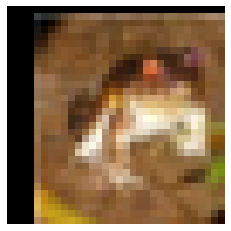

In [150]:
# dataset의 첫 번째 이미지에 대해 random_transform을 해봅니다.
# 여러번 시도하여 정말 random하게 augmentation이 되는지 확인합니다.
plt.imshow(datagen.random_transform(x_train[0]))
plt.axis('off')

`self.datagen.random_transform` 함수를 이용하여, random data augmentation을 적용해봅니다.

In [171]:
class RandomAugmentationGenerator():
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True, datagen=None):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(x_data)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self._get_exploration_order()
            for i in range(0, self.num_samples, self.batch_size):
                batch_ids = indexes[i:i+self.batch_size]
                x, y = self._data_generation(batch_ids)
                yield x, y

    def _get_exploration_order(self):
        indexes = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indexes)
        return indexes

    def _data_generation(self, batch_ids):
        """"mini-batch를 구성하여 return해줍니다."""
        
        ### FILL YOUR OWN CODE (#1) ###
        # batch_ids를 기반으로, mini-batch를 구성합니다.
        batch_size = len(batch_ids)
        x = self.x_data[batch_ids]
        y = self.y_data[batch_ids]

        ###############################
        
        if self.datagen is not None:
            ### FILL YOUR OWN CODE (#2) ###
            # 각 data sample에 대해, data augmentation을 적용해줍니다.
            x= np.array([datagen.random_transform(i) for i in x])
            ###############################

        return x, y

In [172]:
# 새롭게 만든 generator를 정의합니다.
training_generator = RandomAugmentationGenerator(x_train, y_train, batch_size=batch_size, datagen=datagen)

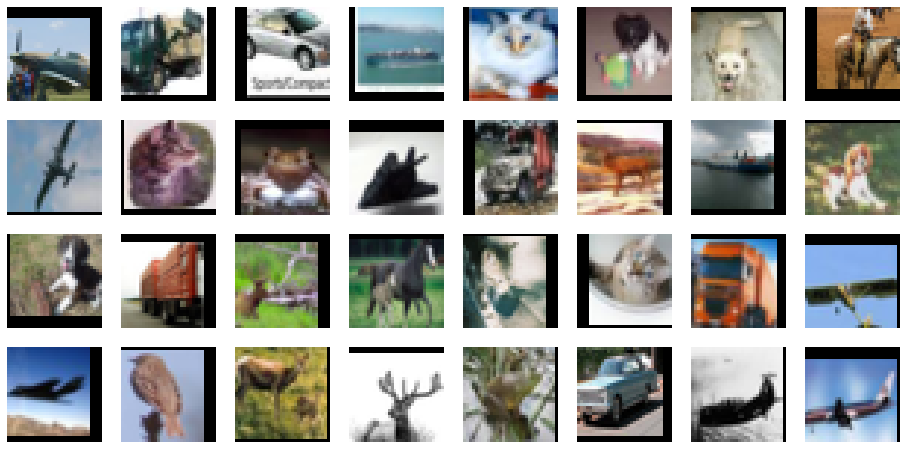

In [174]:
# 새롭게 만든 generator를 이용하여, 어떻게 augmentation되었는지 확인해봅니다.
plot_images(training_generator())

새롭게 정의한 generator를 이용하여, **Task \#1**과 마찬가지로 모델을 학습합니다. 처음부터 다시 학습하기 위해, 모델을 다시 초기화하고, `compile`합니다.

In [176]:
model.load_weights('init_weights.h5') # compile하기 전, 먼저 모델을 초기화해줍니다.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [177]:
history = model.fit_generator(
    generator=training_generator(),
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/30
 - 4s - loss: 2.0562 - acc: 0.2176 - val_loss: 1.8966 - val_acc: 0.3021
Epoch 2/30
 - 3s - loss: 1.7590 - acc: 0.3522 - val_loss: 1.8132 - val_acc: 0.3126
Epoch 3/30
 - 3s - loss: 1.5903 - acc: 0.4140 - val_loss: 1.6526 - val_acc: 0.3921
Epoch 4/30
 - 3s - loss: 1.4716 - acc: 0.4630 - val_loss: 1.5718 - val_acc: 0.4318
Epoch 5/30
 - 4s - loss: 1.3815 - acc: 0.4930 - val_loss: 1.5299 - val_acc: 0.4468
Epoch 6/30
 - 3s - loss: 1.2880 - acc: 0.5263 - val_loss: 1.5058 - val_acc: 0.4622
Epoch 7/30
 - 4s - loss: 1.2144 - acc: 0.5552 - val_loss: 1.6032 - val_acc: 0.4502
Epoch 8/30
 - 3s - loss: 1.1280 - acc: 0.5842 - val_loss: 1.5623 - val_acc: 0.4702
Epoch 9/30
 - 4s - loss: 1.0903 - acc: 0.6001 - val_loss: 1.5238 - val_acc: 0.4892
Epoch 10/30
 - 3s - loss: 1.0165 - acc: 0.6266 - val_loss: 1.6511 - val_acc: 0.4618
Epoch 11/30
 - 3s - loss: 0.9762 - acc: 0.6417 - val_loss: 1.6143 - val_acc: 0.4868
Epoch 12/30
 - 3s - loss: 0.9252 - acc: 0.6654 - val_loss: 1.5736 - val_acc: 0.4918
E

최대 도달 성능: 51.49


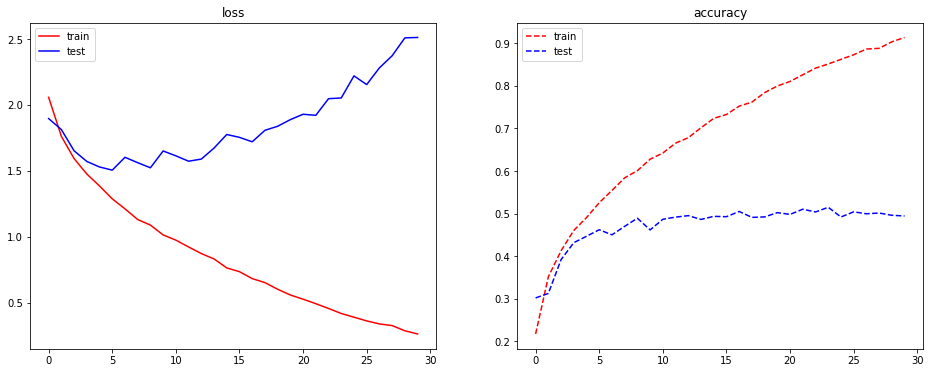

In [179]:
plot_history(history)

# Part 2. Advanced data agumentation techiqnues

**Part 2**에서는 아래의 3가지 data augmentation technique을 배울것입니다. 이를 통해 성능 향상이 어떻게 이루어지는지 확인하고, 데이터 augmentation의 중요성을 배울 것입니다.

* Cutout (https://arxiv.org/pdf/1708.04552.pdf)
* Mixup (https://arxiv.org/abs/1710.09412)
* CutMix (https://arxiv.org/abs/1905.04899)

## Task 3: Mini-batch with Data Augmentation + Cutout

이번 실습에서는 Cutout(https://arxiv.org/pdf/1708.04552.pdf) 알고리즘에 대해 배울것입니다. Cutout이란, 아래의 그림처럼 데이터의 직사각형 형태로 자르는 것을 말합니다.

<img src="cutout.png" width="50%"/>

Cutout 알고리즘은 아래와 같습니다.
1. 각 이미지별로 잘라낼 직사각형의 왼쪽 위 지점을 random하게 선택합니다. (0~31 사이의 정수)
2. 직사각형의 너비와 높이를 random하게 선택합니다. (1~16 사이의 정수)
3. 색칠할 색깔을 random하게 선택합니다. (0~1 사이의 실수)
4. 해당 영역을 선택한 색깔로 색칠합니다.

위의 알고리즘을 `_data_generation` 함수 안에 구현하는 것이 **Task 3**의 목표입니다. 아래의 빈칸 코드를 채워서 cutout된 mini-batch를 만들어보세요.
- 아래의 예제처럼 numpy array `A`에서, `A[1:3, 2:4]`를 하게되면 2x2 sub-matrix를 얻을 수 있습니다. 이를 이용하면 직사각형 부분에 해당하는 영역의 값을 쉽게 수정할 수 있습니다.
- `np.random.randint(N)` 을 이용하면 0, 1, ..., N-1 까지의 숫자 중 하나를 random하게 선택할 수 있습니다.
- `np.random.random()` 을 이용하면 0과 1 사이의 실수중 하나를 random하게 선택할 수 있습니다.
- **아래의 세 가지 내용에 대해 보고서에 첨부해주세요.**
  - 빈칸의 코드
  - `plot_images`를 이용한 image 출력 결과
  - `plot_history`를 이용한 최종 학습 결과
  - 최종 학습 결과를 토대로, over-fitting이 발생했는지 확인해봅니다. 또, 이전의 실험결과과 비교해 어떤 결과가 발생했는지 확인해봅니다.
  - **Cutout되는 면적의 양을 적절히 조절해보세요. 면적의 양에 따라 성능이 달라집니다.**

In [180]:
# numpy array를 다루는 예시입니다.
A = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])

print('전체 행렬:')
print(A)
print('부분 행렬:')
print(A[1:3, 2:4])

A[1:3, 2:4] = 0
print('수정된 전체 행렬:')
print(A)

전체 행렬:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
부분 행렬:
[[ 7  8]
 [11 12]]
수정된 전체 행렬:
[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 9 10  0  0]
 [13 14 15 16]]


In [276]:
class CutoutGenerator():
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True, datagen=None):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(x_data)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self._get_exploration_order()
            for i in range(0, self.num_samples, self.batch_size):
                batch_ids = indexes[i:i+self.batch_size]
                x, y = self._data_generation(batch_ids)
                yield x, y

    def _get_exploration_order(self):
        indexes = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indexes)
        return indexes

    def _data_generation(self, batch_ids):
        """"mini-batch를 구성하여 return해줍니다."""
        
        ### FILL YOUR OWN CODE (#1) ###
        # batch_ids를 기반으로, mini-batch를 구성합니다.
        batch_size = len(batch_ids)
        x = self.x_data[batch_ids]
        y = self.y_data[batch_ids]

        ###############################
        
        if self.datagen is not None:
            ### FILL YOUR OWN CODE (#2) ###
            # 각 data sample에 대해, data augmentation을 적용해줍니다.
            x= np.array([datagen.random_transform(i) for i in x])
            ###############################

        ### FILL YOUR OWN CODE (#3) ###
        # 각 data sample에 대해, Cutout합니다.
        xx = []
        for i in x:
            pos_x,pos_y = np.random.randint(32),np.random.randint(32)
            mask_x,mask_y = np.random.randint(1,10),np.random.randint(5,10)
            mask_color = np.random.random()
            i[pos_x:(pos_x+mask_x),pos_y:(pos_y+mask_y)] = mask_color
            xx.append(i)

        x = np.array(xx)

        ###############################

        return x, y

In [277]:
# 새롭게 만든 generator를 정의합니다.
training_generator = CutoutGenerator(x_train, y_train, batch_size=batch_size, datagen=datagen)

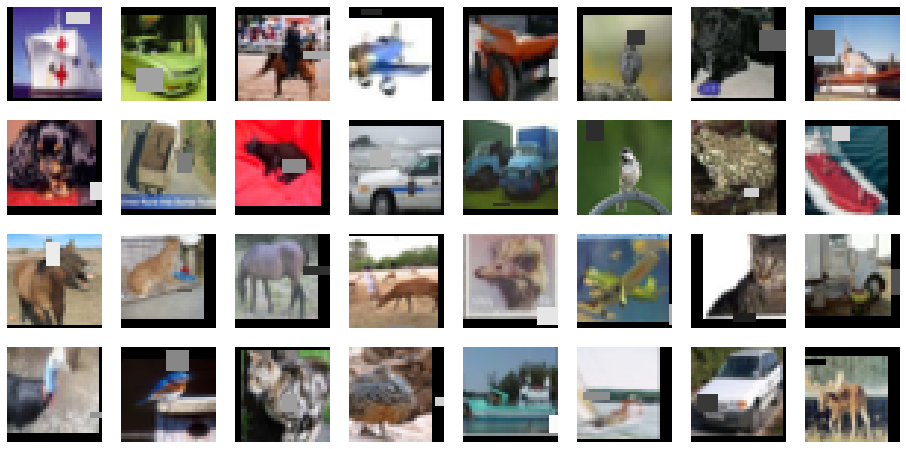

In [278]:
# 새롭게 만든 generator를 이용하여, 어떻게 augmentation되었는지 확인해봅니다.
plot_images(training_generator())

새롭게 정의한 generator를 이용하여, **Task \#1,\#2**와 마찬가지로 모델을 학습합니다. 처음부터 다시 학습하기 위해, 모델을 다시 초기화하고, `compile`해야합니다.

In [279]:
### FILL YOUR OWN CODE (#3) ###
# 1. 모델을 초기화하고, compile합니다.
# 2. 정의한 generator로 모델을 학습합니다.
# 3. 학습 결과를 확인합니다.

In [280]:
model.load_weights('init_weights.h5') # compile하기 전, 먼저 모델을 초기화해줍니다.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit_generator(
    generator=training_generator(),
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/30
 - 5s - loss: 2.0849 - acc: 0.2062 - val_loss: 2.0727 - val_acc: 0.2420
Epoch 2/30
 - 3s - loss: 1.8524 - acc: 0.3053 - val_loss: 1.9092 - val_acc: 0.2784
Epoch 3/30
 - 3s - loss: 1.6924 - acc: 0.3802 - val_loss: 1.7304 - val_acc: 0.3505
Epoch 4/30
 - 4s - loss: 1.5788 - acc: 0.4235 - val_loss: 1.7052 - val_acc: 0.3740
Epoch 5/30
 - 4s - loss: 1.5030 - acc: 0.4521 - val_loss: 1.6638 - val_acc: 0.4079
Epoch 6/30
 - 4s - loss: 1.4032 - acc: 0.4795 - val_loss: 1.6491 - val_acc: 0.4184
Epoch 7/30
 - 3s - loss: 1.3520 - acc: 0.5025 - val_loss: 1.5560 - val_acc: 0.4535
Epoch 8/30
 - 4s - loss: 1.2792 - acc: 0.5244 - val_loss: 1.5872 - val_acc: 0.4477
Epoch 9/30
 - 4s - loss: 1.2234 - acc: 0.5496 - val_loss: 1.5619 - val_acc: 0.4654
Epoch 10/30
 - 4s - loss: 1.1745 - acc: 0.5718 - val_loss: 1.5578 - val_acc: 0.4708
Epoch 11/30
 - 4s - loss: 1.1131 - acc: 0.5899 - val_loss: 1.6097 - val_acc: 0.4542
Epoch 12/30
 - 4s - loss: 1.0674 - acc: 0.6097 - val_loss: 1.5644 - val_acc: 0.4758
E

최대 도달 성능: 51.57


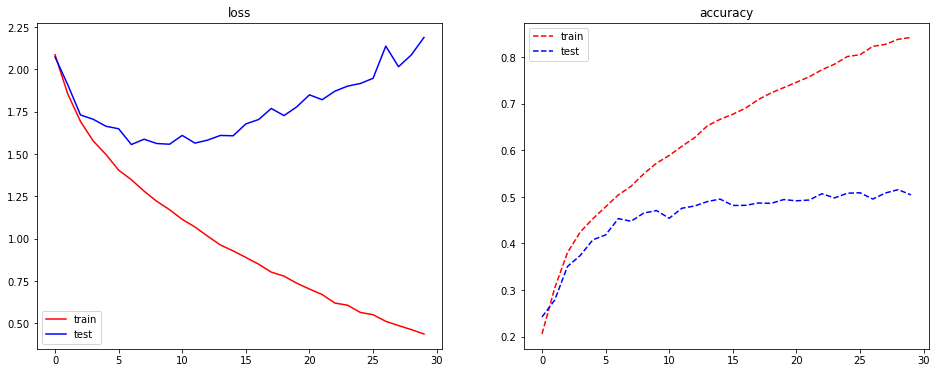

In [281]:
plot_history(history)

## Task 4: Mini-batch with Data Augmentation + Mixup

이번 실습에서는 Mixup(https://arxiv.org/abs/1710.09412) 알고리즘에 대해 배울것입니다. Cutout이란, 아래의 그림처럼 두 개의 데이터를 random한 비율로 섞는 것을 말합니다. 두 개의 데이터를 섞게되므로, label 또한 같은 비율로 섞이게 됩니다. 아래의 그림을 예로 들면, 고양이 40%, 개 60%의 비율로 이미지를 mixup한다고 생각해보면, 이미지는 두 이미지가 4:6으로 섞인 것처럼 표현됩니다. 이 때 label은 개 0.4, 고양이 0.6의 확률로 나타나야합니다.

<img src="mixup.png" width="70%"/>

Mixup 알고리즘은 아래와 같습니다.
1. 배치 안의 각 이미지마다, 섞을 이미지를 random하게 선택합니다.
2. 섞을 비율을 beta distribution으로부터 random하게 선택합니다. (0~1 사이의 실수)
3. 이미지(`x`)와 label(`y`)을 섞어서 `x_mixed`, `y_mixed`에 저장합니다.
4. mixup된 배치를 사용하여 학습합니다.

위의 알고리즘을 `_data_generation` 함수 안에 구현하는 것이 **Task 4**의 목표입니다. 아래의 빈칸 코드를 채워서 mixup된 mini-batch를 만들어보세요.
- `np.random.randint(n)`을 이용하면 정수 0, 1, ..., n-1 중 하나를 random sampling할 수 있습니다.
- `np.random.beta(self.alpha, self.alpha)`를 이용하면 beta distribution에서 0~1 사이의 실수를 random sampling할 수 있습니다.
- **아래의 세 가지 내용에 대해 보고서에 첨부해주세요.**
  - 빈칸의 코드
  - `plot_images`를 이용한 image 출력 결과
  - `plot_history`를 이용한 최종 학습 결과
  - 최종 학습 결과를 토대로, over-fitting이 발생했는지 확인해봅니다. 또, 이전의 실험결과과 비교해 어떤 결과가 발생했는지 확인해봅니다.
  - **Over-fitting이 만약 발생하지 않았다면 학습을 더 오래하여 학습해보세요.** (`validation_freq`를 조절하여 학습을 좀 더 빨리할 수 있습니다.)
  - **Mixup의 섞는 비율을 결정하는 beta distribution의 parameter `alpha`를 조절했을 때, 결과가 어떻게 달라지는지 확인해보세요.**

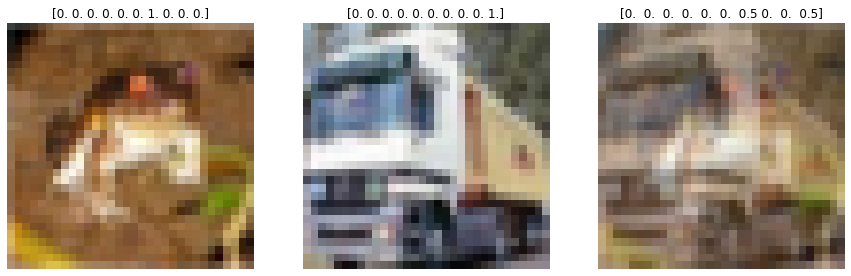

In [282]:
# 예제
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_train[0])
plt.axis('off')
plt.title(str(y_train[0]))

plt.subplot(1, 3, 2)
plt.imshow(x_train[1])
plt.axis('off')
plt.title(str(y_train[1]))

plt.subplot(1, 3, 3)
plt.imshow(x_train[0]*0.5 + x_train[1]*0.5)
plt.axis('off')
plt.title(str(y_train[0]*0.5+y_train[1]*0.5))

None

In [314]:
class MixupGenerator():
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True, alpha=2, datagen=None):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(x_data)
        self.alpha = alpha
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self._get_exploration_order()
            for i in range(0, self.num_samples, self.batch_size):
                batch_ids = indexes[i:i+self.batch_size]
                x, y = self._data_generation(batch_ids)
                yield x, y

    def _get_exploration_order(self):
        indexes = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indexes)
        return indexes

    def _data_generation(self, batch_ids):
        """"mini-batch를 구성하여 return해줍니다."""
        
        ### FILL YOUR OWN CODE (#1) ###
        # batch_ids를 기반으로, mini-batch를 구성합니다.
        batch_size = len(batch_ids)
        x = self.x_data[batch_ids]
        y = self.y_data[batch_ids]

        ###############################
        
        if self.datagen is not None:
            ### FILL YOUR OWN CODE (#2) ###
            # 각 data sample에 대해, data augmentation을 적용해줍니다.
            x= np.array([datagen.random_transform(i) for i in x])
            ###############################


        x_mixed = np.zeros_like(x)
        y_mixed = np.zeros_like(y)

        ### FILL YOUR OWN CODE (#4) ###
        # random하게 다른 sample을 선택하여, mixup하여 batch를 새롭게 구성합니다.
        for i in range(batch_size):
            x_a = np.random.randint(batch_size)
            r_a = np.random.beta(self.alpha, self.alpha)
            r_i = 1-r_a
            x_mixed[i] = x[i]*r_i + x[x_a]*r_a
            y_mixed[i] = y[i]*r_i + y[x_a]*r_a


        return x_mixed, y_mixed

In [315]:
# 새롭게 만든 generator를 정의합니다.
training_generator = MixupGenerator(x_train, y_train, batch_size=batch_size, datagen=datagen, alpha=2)

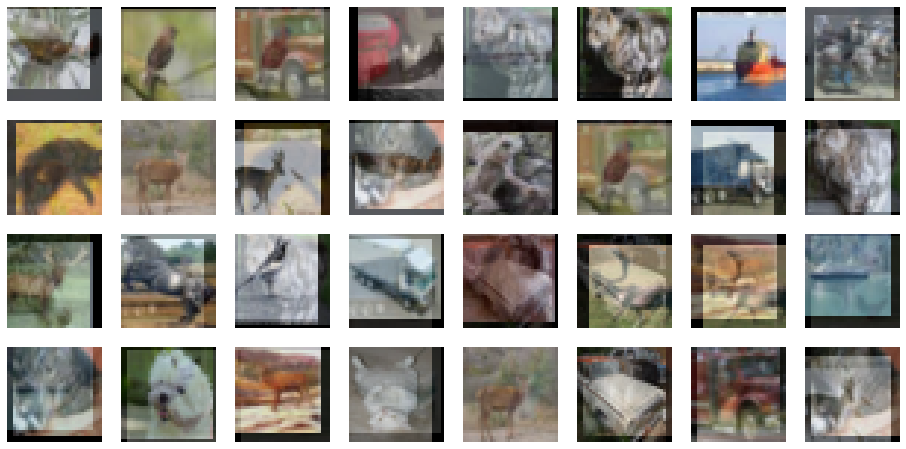

In [316]:
# 새롭게 만든 generator를 이용하여, 어떻게 augmentation되었는지 확인해봅니다.
plot_images(training_generator())

In [307]:
### FILL YOUR OWN CODE (#4) ###
# 1. 모델을 초기화하고, compile합니다.
# 2. 정의한 generator로 모델을 학습합니다.
# 3. 학습 결과를 확인합니다.

In [320]:
model.load_weights('init_weights.h5') # compile하기 전, 먼저 모델을 초기화해줍니다.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit_generator(
    generator=training_generator(),
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs+70,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/100
 - 5s - loss: 2.2332 - acc: 0.1508 - val_loss: 2.1119 - val_acc: 0.2116
Epoch 2/100
 - 4s - loss: 2.1519 - acc: 0.2121 - val_loss: 1.9405 - val_acc: 0.2831
Epoch 3/100
 - 4s - loss: 2.0845 - acc: 0.2597 - val_loss: 1.9146 - val_acc: 0.3087
Epoch 4/100
 - 4s - loss: 2.0249 - acc: 0.3012 - val_loss: 1.7678 - val_acc: 0.3606
Epoch 5/100
 - 4s - loss: 1.9954 - acc: 0.3124 - val_loss: 1.7117 - val_acc: 0.3832
Epoch 6/100
 - 4s - loss: 1.9538 - acc: 0.3420 - val_loss: 1.7149 - val_acc: 0.3814
Epoch 7/100
 - 4s - loss: 1.9219 - acc: 0.3552 - val_loss: 1.7338 - val_acc: 0.3635
Epoch 8/100
 - 4s - loss: 1.8975 - acc: 0.3730 - val_loss: 1.6985 - val_acc: 0.3796
Epoch 9/100
 - 4s - loss: 1.8697 - acc: 0.3859 - val_loss: 1.6218 - val_acc: 0.4154
Epoch 10/100
 - 4s - loss: 1.8470 - acc: 0.4063 - val_loss: 1.6219 - val_acc: 0.4170
Epoch 11/100
 - 4s - loss: 1.8314 - acc: 0.4157 - val_loss: 1.5382 - val_acc: 0.4500
Epoch 12/100
 - 4s - loss: 1.8171 - acc: 0.4240 - val_loss: 1.5191 - val_a

Epoch 98/100
 - 4s - loss: 1.2746 - acc: 0.7738 - val_loss: 1.3925 - val_acc: 0.5496
Epoch 99/100
 - 4s - loss: 1.2821 - acc: 0.7669 - val_loss: 1.3580 - val_acc: 0.5543
Epoch 100/100
 - 4s - loss: 1.2763 - acc: 0.7682 - val_loss: 1.3417 - val_acc: 0.5614


최대 도달 성능: 56.46


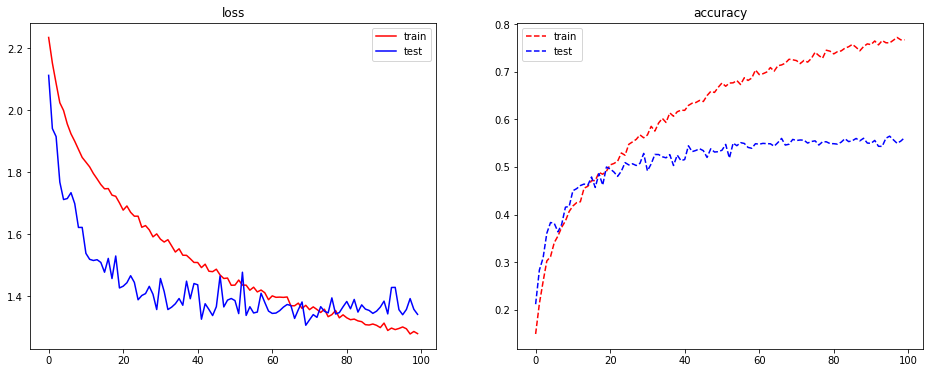

In [321]:
plot_history(history)

아래의 script는 `alpha` 에 따라 beta distribution이 어떻게 변하는지를 보여줍니다. 이를 이용해 `alpha=2`일때는 어떤 값들이 주로 sampling되는지를 확인하고, 여러가지 `alpha`를 테스트해보세요.

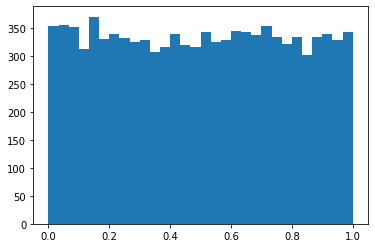

In [319]:
samples = []
alpha = 1
for _ in range(10000):
    l = np.random.beta(alpha, alpha)
    samples.append(l)
plt.hist(samples, bins=30)
None

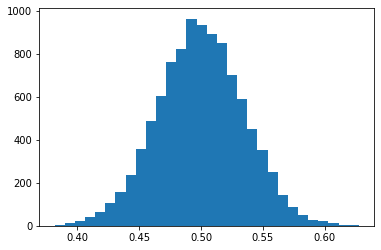

In [336]:
samples = []
alpha = 100
for _ in range(10000):
    l = np.random.beta(alpha, alpha)
    samples.append(l)
plt.hist(samples, bins=30)
None

## Task 5: Mini-batch with Data Augmentation + CutMix (Mixup + Cutout)

이번 실습에서는 Mixup과 Cutout 두가지를 동시에 사용하는 방법인 CutMix(https://arxiv.org/abs/1905.04899) 알고리즘에 대해 배울것입니다. CutMix란, 특정 영역을 잘라내서, 그 부분을 다른 이미지로 채워넣는 것을 말합니다. 여기서 섞인 비율은 면적 비율이라고 생각할 수 있습니다. 예를 들어, 아래 그림에서는 고양이 30%, 강아지 70% 정도로 섞였다고 보고 mixed label을 만들 수 있습니다.

<img src="cutmix.png" width="70%"/>

**Task 5**에서는 위의 간단한 description 혹은 논문을 직접 참고(https://arxiv.org/pdf/1905.04899.pdf) 하여 CutMix를 구현해보는 것이 목표입니다.
- **아래의 세 가지 내용에 대해 보고서에 첨부해주세요.**
  - 빈칸의 코드
  - `plot_images`를 이용한 image 출력 결과
  - `plot_history`를 이용한 최종 학습 결과
  - 최종 학습 결과를 토대로, over-fitting이 발생했는지 확인해봅니다. 또, 이전의 실험결과과 비교해 어떤 결과가 발생했는지 확인해봅니다.
  - **성능을 최대한 향상시켜보세요.**

In [443]:
class CutMixGenerator():
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True, datagen=None, alpha=0.5):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(x_data)
        self.datagen = datagen
        self.alpha = alpha

    def __call__(self):
        while True:
            indexes = self._get_exploration_order()
            for i in range(0, self.num_samples, self.batch_size):
                batch_ids = indexes[i:i+self.batch_size]
                x, y = self._data_generation(batch_ids)
                yield x, y

    def _get_exploration_order(self):
        indexes = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indexes)
        return indexes

    def _data_generation(self, batch_ids):
        ### FILL YOUR OWN CODE (#5) ###
        batch_size = len(batch_ids)
        x = self.x_data[batch_ids]
        y = self.y_data[batch_ids]

        x_mixed = np.zeros_like(x)
        y_mixed = np.zeros_like(y)
        
        for i in range(batch_size):
            pos_x,pos_y = np.random.randint(31),np.random.randint(31)
            mask_x,mask_y = np.random.randint(2,30)+6,np.random.randint(2,30)+6
            
            x_a = np.random.randint(batch_size)
            x[i][pos_x:(pos_x+mask_x),pos_y:(pos_y+mask_y)] = x[x_a][pos_x:(pos_x+mask_x),pos_y:(pos_y+mask_y)]
            aa = x[i][pos_x:(pos_x+mask_x),pos_y:(pos_y+mask_y)]
            
            area_ratio = len(aa[0])*len(aa[1])/32/32
                      
            x_mixed[i] = x[i]
            y_mixed[i] = y[i]*(1-area_ratio) + y[x_a]*area_ratio


        return x_mixed, y_mixed
        ###############################

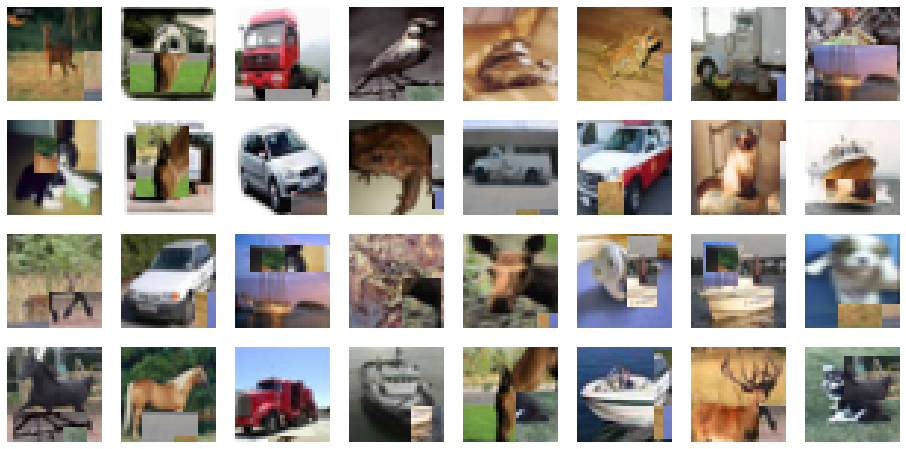

In [444]:
### FILL YOUR OWN CODE (#5) ###
# 1. 새롭게 만든 generator를 정의합니다.
# 2. 새롭게 만든 generator를 이용하여, 어떻게 augmentation되었는지 확인해봅니다.
###############################
# 새롭게 만든 generator를 정의합니다.
training_generator = CutMixGenerator(x_train, y_train, batch_size=batch_size)
plot_images(training_generator())

In [456]:
### FILL YOUR OWN CODE (#5) ###
# 1. 모델을 초기화하고, compile합니다.
# 2. 정의한 generator로 모델을 학습합니다.
# 3. 학습 결과를 확인합니다.

model.load_weights('init_weights.h5') # compile하기 전, 먼저 모델을 초기화해줍니다.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit_generator(
    generator=training_generator(),
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/30
 - 4s - loss: 2.1555 - acc: 0.1918 - val_loss: 1.8805 - val_acc: 0.3167
Epoch 2/30
 - 3s - loss: 1.9891 - acc: 0.3053 - val_loss: 1.7242 - val_acc: 0.3684
Epoch 3/30
 - 3s - loss: 1.8788 - acc: 0.3586 - val_loss: 1.6519 - val_acc: 0.3973
Epoch 4/30
 - 3s - loss: 1.7824 - acc: 0.4011 - val_loss: 1.5936 - val_acc: 0.4132
Epoch 5/30
 - 3s - loss: 1.7093 - acc: 0.4462 - val_loss: 1.6095 - val_acc: 0.4147
Epoch 6/30
 - 3s - loss: 1.6576 - acc: 0.4783 - val_loss: 1.5804 - val_acc: 0.4261
Epoch 7/30
 - 3s - loss: 1.5810 - acc: 0.5181 - val_loss: 1.5155 - val_acc: 0.4586
Epoch 8/30
 - 3s - loss: 1.5310 - acc: 0.5484 - val_loss: 1.5177 - val_acc: 0.4474
Epoch 9/30
 - 3s - loss: 1.4413 - acc: 0.6025 - val_loss: 1.5158 - val_acc: 0.4537
Epoch 10/30
 - 3s - loss: 1.3914 - acc: 0.6312 - val_loss: 1.4777 - val_acc: 0.4893
Epoch 11/30
 - 3s - loss: 1.3430 - acc: 0.6649 - val_loss: 1.4806 - val_acc: 0.4866
Epoch 12/30
 - 3s - loss: 1.3050 - acc: 0.6856 - val_loss: 1.5302 - val_acc: 0.4790
E

최대 도달 성능: 50.45


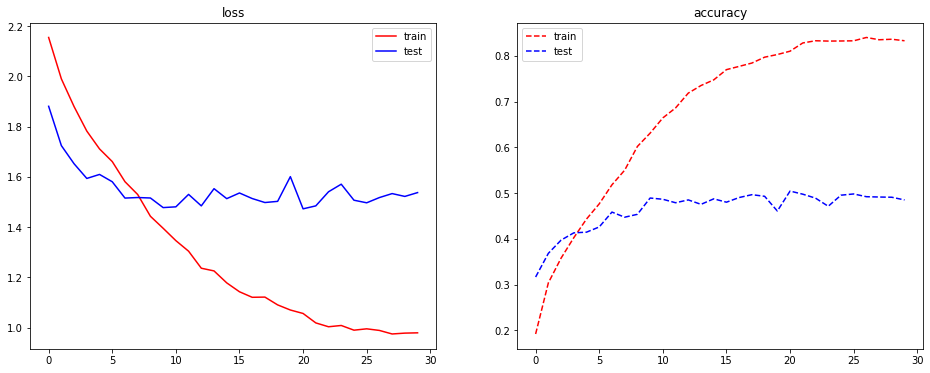

In [457]:
plot_history(history)

# Part 3. Other Techinques (Optional)

## Task 6: Dropout

이번 실습에서는 Dropout(http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)을 이용하여 neural network를 확률적으로 모델링했을 때 생기는 regularization 효과에 대해 배울것입니다. Dropout은 각 activation 값을 확률적으로 drop(0으로 만듦)하는 방법입니다. 아래 그림과 같이, 매 연산시마다 새로운 network를 고려하는 형태가 됩니다.

<img src="dropout.PNG" width="70%"/>

**Task 6**에서는 간단한 MLP를 학습해볼 것입니다. 일반적으로 MLP는 학습이 잘 되지 않지만, Dropout을 사용함으로써 성능을 향상시킬 수 있습니다. `tf.keras.layers.Dropout`을 이용하여 Dropout이 들어간 model을 작성해보고, 성능 변화를 관측해보세요. **Dropout layer에서, drop하는 확률을 조절하여 성능 변화를 관측해보세요.**

In [ ]:
# 본 실습에서 사용할 데이터셋인 fashion_mnist를 import합니다.
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
# fashion_mnist 데이터를 로드합니다.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### 데이터 전처리 과정
이미지의 pixel 의 값은 (R, G, B) 형태로 표현되고, 각 channel (R/G/B) 마다 0부터 255 중 하나의 정수 값을 가집니다. 인공신경망은 일반적으로 실수형 데이터를 처리하기에 적합합니다. 또라서, 다음과 같이 0부터 1 사이의 실수값으로 변경해줍니다.

In [ ]:
# 이미지 값을 0부터 1 사이의 값으로 변경합니다.
x_train = x_train / 255.0
x_test = x_test / 255.0

label의 값은 0부터 9까지의 정수로 표현됩니다. classification 문제를 풀 때는 일반적으로 one-hot encoding을 하여 확률값처럼 고려할 수 있도록 합니다. 아래의 keras API를 이용해 one-hot encoding으로 바꾸어줍니다.

In [ ]:
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# fashion_mnist 데이터를 확인합니다.
plot_images(x_train)

Dropout을 사용하기에 앞서, Dropout이 없는 모델을 먼저 사용하여 성능을 확인해봅니다.

In [ ]:
# Keras API를 이용하여 모델을 정의합니다.
MLP = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
MLP.save_weights('init_MLP_weights.h5') # 모델 inital weight를 저장해줍니다.

In [ ]:
MLP.load_weights('init_MLP_weights.h5') # compile하기 전, 먼저 모델을 초기화해줍니다.
MLP.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Data Generator 없이 사용할 때에는 `fit` 함수만 사용하여서 더 쉽게 모델을 학습해볼 수 있습니다.

In [ ]:
history = MLP.fit(x_train, y_train,
                  batch_size=128,
                  epochs=100,
                  validation_data=(x_test, y_test),
                  verbose=2)

In [ ]:
plot_history

In [ ]:
### FILL YOUR OWN CODE (#6) ###
# Keras API를 사용하여 Dropout이 포함된 모델을 정의해보세요.
MLP_dropout = tf.keras.models.Sequential([
    ?
])
MLP_dropout.save_weights('init_MLP_dropout_weights.h5') # 모델 inital weight를 저장해줍니다.

In [ ]:
### FILL YOUR OWN CODE (#6) ###
# Keras API를 모델을 초기화하고, complie하세요.


In [ ]:
### FILL YOUR OWN CODE (#6) ###
# Keras API인 fit 함수를 이용하여 모델을 학습해보고, 학습 결과를 plot_history를 이용하여 확인해보세요.


In [ ]:
plot_history(history)

## Task 7: Weight Regularization

이번 실습에서는 Weight Regularization을 이용하여 neural network의 weight에 제한을 주는 방법을 배울것입니다. 아래 그림처럼 weight에 regularization을 주는 방법은 일반적으로는 $l_2$ loss를 사용하지만, 경우에 따라 $l_1$ loss 혹은 강의에서 배우신 것처럼 $l_0$ loss를 approximiation하여 사용합니다.

<img src="reg.png" width="70%"/>

**Task 7**에서는 MLP에 다양한 regularization을 주고 학습해볼 것입니다. Keras에서는 총 $l_2$ 와 $l_1$ regularizer와, 그 둘의 혼합 형태의 로스를 제공합니다. (https://keras.io/regularizers/ 참고하시면 어떻게 regularizer를 줄 수 있는지 나옵니다.) 
* $l_1$ loss의 비중을 `0.0001`로 주고 모델을 학습해보세요.
* `plot_weights` 함수를 이용해 weight의 분포를 확인해보세요. 또, $l_2$ 를 사용했을 때와 비교해보세요. 어떤 효과가 있나요? 또 어디에 유용할까요?

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
def plot_weights(m):
    """model의 weight의 분포를 plot해줍니다."""
    plt.figure(figsize=(10,10))
    for i in range(1, 4):
        weights, biases = m.layers[i].get_weights()
        plt.subplot(3, 2, i*2-1)
        plt.hist(weights.reshape((-1,)), bins=100)
        plt.title('layer ' + str(i) + ' weight')
        plt.subplot(3, 2, i*2)
        plt.hist(biases.reshape((-1,)), bins=100)
        plt.title('layer ' + str(i) + ' bias')
        print('layer {}에서, 크기가 0.1 보다 작은 weight의 비율 = {:.2f}%'.format(i, 100*np.mean(weights.reshape((-1,)) < 0.1)))

In [ ]:
# 기존에 학습한 모델의 weight 분포를 보여줍니다.
plot_weights(MLP)

In [ ]:
### FILL YOUR OWN CODE (#7) ###
# Keras API를 사용하여 l1 regularizer를 사용한 모델을 정의해보세요.
MLP_l1 = tf.keras.models.Sequential([
    ?
])
MLP_l1.save_weights('init_MLP_l1_weights.h5') # 모델 inital weight를 저장해줍니다.

In [ ]:
### FILL YOUR OWN CODE (#7) ###
# Keras API를 모델을 초기화하고, complie하세요.


In [ ]:
### FILL YOUR OWN CODE (#6) ###
# Keras API인 fit 함수를 이용하여 모델을 학습해보고, 학습 결과를 plot_history를 이용하여 확인해보세요.


# 고생하셨습니다!